We start with a simple classification task using LwP (Learning with Prototypes) and see how we can evolve to probabilistic ML.

# Learning with a Projection (LwP)

**Learning with a Projection (LwP)** is an approach to metric learning where we aim to transform data using a shared projection matrix such that simple distance measures (like Euclidean) become meaningful for tasks like classification, clustering, or anomaly detection.

### 🔍 Motivation

In real-world data, clusters often have different shapes (covariances), making standard Euclidean distance unreliable. Mahalanobis distance corrects for this by incorporating covariance, but it typically works **locally** (per class/cluster). To make distance meaningful **globally**, we need a shared transformation.

---

### 🧠 Core Idea

LwP learns a global **linear transformation matrix** \( A \), or equivalently a **symmetric positive definite matrix** \( M = A^\top A \), such that:

\[
D_M(\mathbf{x}, \mathbf{y}) = \sqrt{(\mathbf{x} - \mathbf{y})^\top M (\mathbf{x} - \mathbf{y})}
\]

This generalized Mahalanobis distance stretches and rotates the space so that:

- **Similar points** are pulled closer,
- **Dissimilar points** are pushed farther apart,
- And the transformed data aligns better with Euclidean geometry.

---

### 🎯 Example: Whitening via PCA

PCA whitening can be viewed as a crude form of LwP, where the projection is chosen to decorrelate features and normalize variances. In LwP, however, we learn a projection **with supervision**, targeting task-specific structure (e.g. class separation).

---

### ✅ Applications

- k-NN classification with learned distance
- Clustering with shared shape-aware metric
- Face and object recognition (e.g., deep metric learning)
- Anomaly detection using global Mahalanobis distance

---

### 🧩 Summary

LwP enables the use of **one shared metric space** across all data, turning Euclidean distance into a powerful tool for structured tasks — especially when raw space is misaligned or distorted by different data covariances.


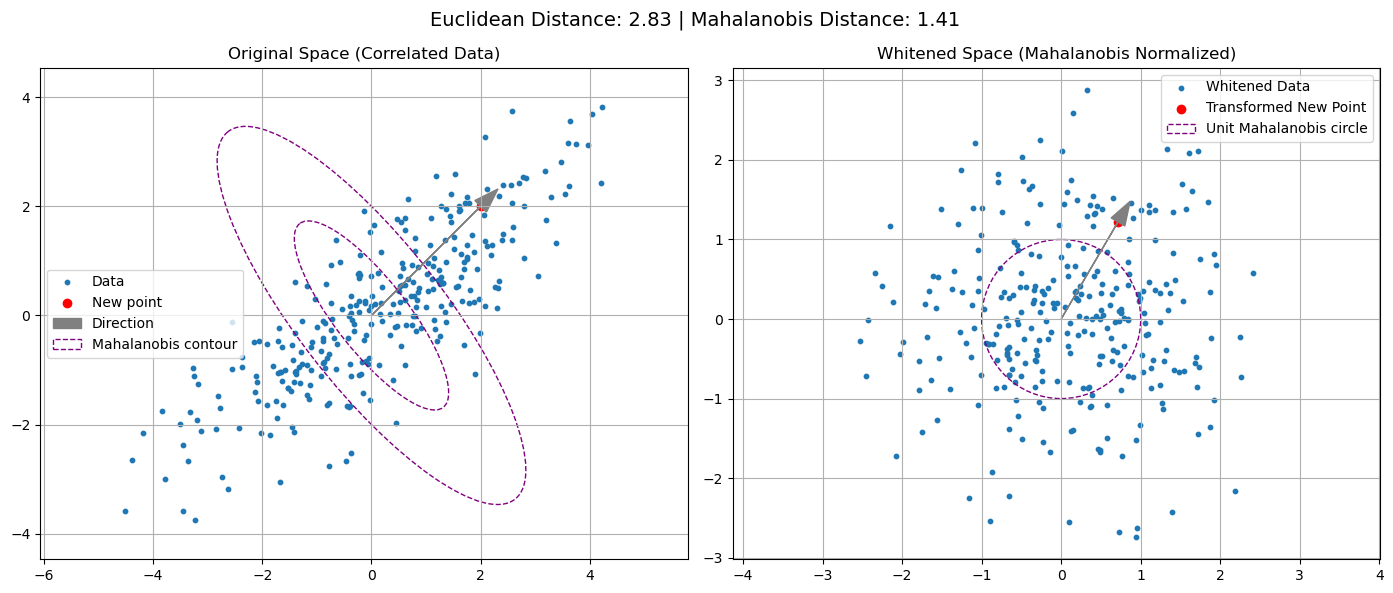

As can be seen above, the use of the covariance matrix morphs space to convert the mahalanobis distance into a euclidean distance. 
This is the essence of the whitening transformation. 
However, at a time we can only use one covariance matrix, so a better idea is to use a new metric 
(new symmetric matrix) that is specific to the problem here


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.spatial import distance

# Seed for reproducibility
np.random.seed(0)

# Create correlated 2D Gaussian data
mean = np.array([0, 0])
cov = np.array([[3.0, 2.0],
                [2.0, 2.0]])  # Strong correlation between x and y

# Sample points
X = np.random.multivariate_normal(mean, cov, size=300)

# New point to measure distance from mean
x_new = np.array([2, 2])

# Compute Euclidean and Mahalanobis distance
inv_cov = np.linalg.inv(cov)
d_euclidean = np.linalg.norm(x_new - mean)
d_mahalanobis = distance.mahalanobis(x_new, mean, inv_cov)

# Transform data with whitening (Mahalanobis transformation)
eigvals, eigvecs = np.linalg.eigh(cov)
W = eigvecs @ np.diag(1 / np.sqrt(eigvals)) @ eigvecs.T  # Whitening matrix
X_whitened = X @ W.T
x_new_whitened = x_new @ W.T

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# ----- Left: Original space -----
axs[0].scatter(X[:, 0], X[:, 1], s=10, label='Data')
axs[0].scatter(*x_new, color='red', label='New point')
axs[0].arrow(*mean, *(x_new - mean), color='gray', head_width=0.3, label='Direction')
axs[0].set_title("Original Space (Correlated Data)")

# Plot 1-sigma and 2-sigma ellipses (Mahalanobis level sets)
vals, vecs = np.linalg.eigh(cov)
for nsig in [1, 2]:
    width, height = 2 * nsig * np.sqrt(vals)
    angle = np.degrees(np.arctan2(*vecs[:, 1][::-1]))
    ellipse = Ellipse(mean, width, height, angle=angle, edgecolor='purple',
                      facecolor='none', linestyle='--', label='Mahalanobis contour' if nsig == 1 else None)
    axs[0].add_patch(ellipse)

axs[0].legend()
axs[0].axis('equal')
axs[0].grid(True)

# ----- Right: Whitened space -----
axs[1].scatter(X_whitened[:, 0], X_whitened[:, 1], s=10, label='Whitened Data')
axs[1].scatter(*x_new_whitened, color='red', label='Transformed New Point')
axs[1].add_patch(Ellipse((0, 0), 2, 2, edgecolor='purple',
                         facecolor='none', linestyle='--', label='Unit Mahalanobis circle'))
axs[1].arrow(0, 0, *(x_new_whitened), color='gray', head_width=0.2)
axs[1].set_title("Whitened Space (Mahalanobis Normalized)")

axs[1].legend()
axs[1].axis('equal')
axs[1].grid(True)

plt.suptitle(f"Euclidean Distance: {d_euclidean:.2f} | Mahalanobis Distance: {d_mahalanobis:.2f}", fontsize=14)
plt.tight_layout()
plt.show()
print("As can be seen above, the use of the covariance matrix morphs space to convert the mahalanobis distance into a euclidean distance. \nThis is the essence of the whitening transformation. \nHowever, at a time we can only use one covariance matrix, so a better idea is to use a new metric \n(new symmetric matrix) that is specific to the problem here")


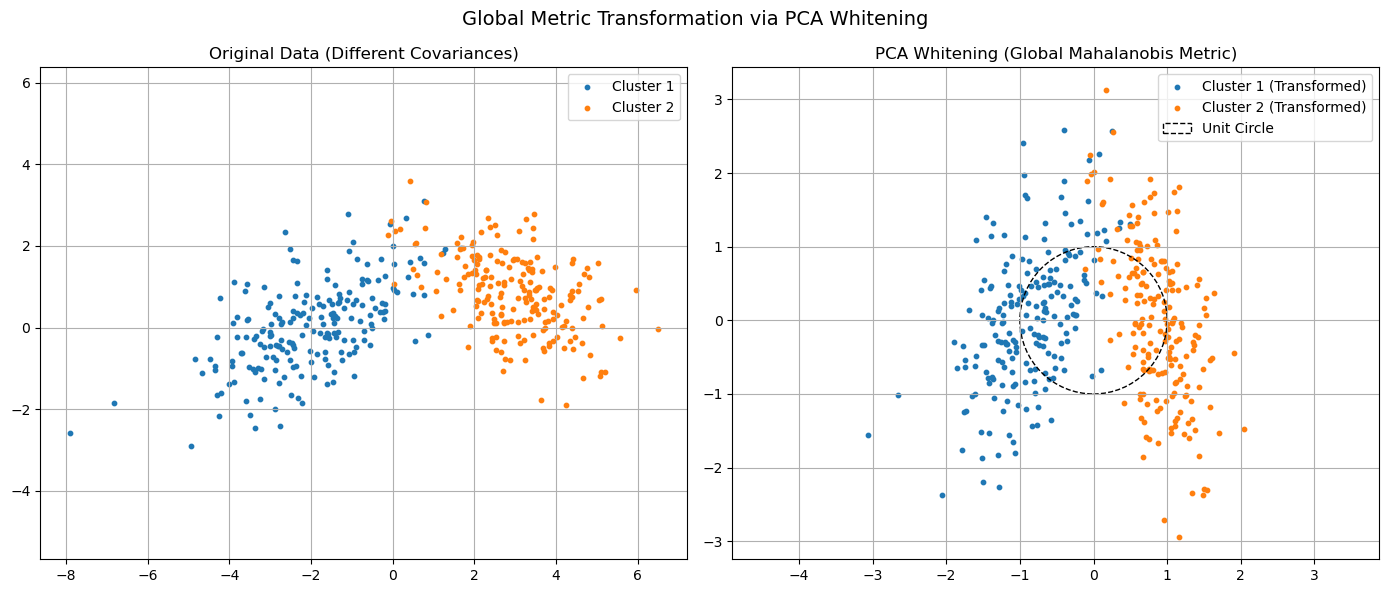

In [13]:
from scipy.spatial import distance
from sklearn.decomposition import PCA

# Seed for reproducibility
np.random.seed(2)

# Define two clusters with different covariance
mean1 = np.array([-2, 0])
cov1 = np.array([[2.0, 0.8],
                 [0.8, 1.0]])

mean2 = np.array([3, 1])
cov2 = np.array([[1.5, -0.6],
                 [-0.6, 1.0]])

X1 = np.random.multivariate_normal(mean1, cov1, size=200)
X2 = np.random.multivariate_normal(mean2, cov2, size=200)
X = np.vstack((X1, X2))
y = np.array([0]*200 + [1]*200)

# Let's pretend we're "learning" a metric:
# We’ll compute a global whitening matrix using PCA — this simulates a shared M
pca = PCA(whiten=True)
X_transformed = pca.fit_transform(X)

# Plot original data
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].scatter(X1[:, 0], X1[:, 1], s=10, label='Cluster 1')
axs[0].scatter(X2[:, 0], X2[:, 1], s=10, label='Cluster 2')
axs[0].set_title("Original Data (Different Covariances)")
axs[0].axis('equal')
axs[0].legend()
axs[0].grid(True)

# Plot PCA-whitened data
axs[1].scatter(X_transformed[y == 0, 0], X_transformed[y == 0, 1], s=10, label='Cluster 1 (Transformed)')
axs[1].scatter(X_transformed[y == 1, 0], X_transformed[y == 1, 1], s=10, label='Cluster 2 (Transformed)')
axs[1].add_patch(Ellipse((0, 0), 2, 2, edgecolor='black', facecolor='none', linestyle='--', label='Unit Circle'))
axs[1].set_title("PCA Whitening (Global Mahalanobis Metric)")
axs[1].axis('equal')
axs[1].legend()
axs[1].grid(True)

plt.suptitle("Global Metric Transformation via PCA Whitening", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
from scipy.stats import norm
from scipy.stats import rv_continuous
from scipy.integrate import quad

# Define the PDF of Y = X^3 where X ~ N(0, 1)
# Let’s compute the distribution of Y using transformation of variables

# We'll define the PDF of Y using the method for monotonic transformations:
# If Y = g(X) = X^3 and g is monotonic, then:
# f_Y(y) = f_X(g^{-1}(y)) * |d/dy g^{-1}(y)|

# Since Y = X^3, then X = Y^{1/3}, and d/dy X = (1/3)*y^{-2/3}
# But this is valid only for y != 0. Since x^3 is monotonic, we can use the inverse rule.

def f_Y(y):
    if y == 0:
        return norm.pdf(0) / np.cbrt(1e-10)**2  # handle 0 carefully
    x = np.cbrt(y)  # inverse
    return norm.pdf(x) / (3 * np.abs(x)**2)

# Generate Y values from its PDF using rejection sampling
y_vals = []
x_support = np.linspace(-4, 4, 10000)
max_fY = max([f_Y(y) for y in np.linspace(-30, 30, 1000)])  # rough upper bound

num_samples = 10000
samples_Y = []
attempts = 0
while len(samples_Y) < num_samples and attempts < num_samples * 10:
    y_cand = np.random.uniform(-30, 30)
    u = np.random.uniform(0, max_fY)
    if u < f_Y(y_cand):
        samples_Y.append(y_cand)
    attempts += 1

# Create sorted sample pairs (x_i, y_i) where y_i is sampled and x_i = y_i^{1/3}
samples_Y = np.array(samples_Y)
samples_X = np.cbrt(samples_Y)  # back-calculate X

# Scatter plot of (X, Y) based on sampled Y
plt.figure(figsize=(6, 5))
plt.scatter(samples_X, samples_Y, alpha=0.3, s=5, color='green')
plt.title("Sampled from Y, then mapped to X = Y^{1/3}")
plt.xlabel("X = Y^{1/3}")
plt.ylabel("Y")
plt.grid(True)
plt.show()


# Binary Cross Entropy

Even with the improvement made in the previous section, the transformed data clusters will just be treated as two points, their means, as prototypes. A better approach is the find the ***probability distribution of data***, to use more information than just the mean and the covariance of the data, and for more diverse tasks.

## How does probability fit in with ML?
Machine Learning is the process of using algoritmhs to train a model to "learn" the distribution of input data, with the goal to make predictions on unseen data and generate new samples of data.  
As an example, consider trying to generate images of cats. The goal of the algorithm is to create an object that tries to replicate the distribution of the input data, here the images of cats, and then sample from it. This is like assigning probabilities to regions of whatever high dimensional space these images are in.  
More precisely, when we say learning the distribution, it means we are assigning probabilities to regions of space that reflect how "typical" it is in the overall scheme of things (P(image)).

## Entropy
Entropy is a way of quantifying how much a distribution would "surprise" us. Thus, if we know a distribution P is say x->0.8 and y->0.2, and we took samples from it, we would be "surprised" everytime we got a y over x. This is where the true "randomness" of the distribution is felt.   
   
Thus, it makes sense that we need a function whose domain is the sample space and whose value is increased by outcomes that are associated with less probability, and additive over successive "surprises".
One such function is the function $$h(s) = \log\left(\frac{1}{p(s)}\right) \text{which is called }\textbf{surprise } \text{H(P).} \text{ Entropy is the expected value of this function, i.e. }\mathbb{E}[h(s)]$$

## Cross Entropy
Now often in real applications, we do not know what the actual distribution is that a random experiment follows, we can only make a good guess.   
So a natural question is, how much randomness is actually there in the actual distribution P, and how much are we seeing simply because our guess Q is not accurate? 
    
This is where it makes sense to use cross-entropy, which we get by taking the expected value of the surprise function over the actual distribution, i.e. $$H(P, Q) = -\sum_{x} p(x) \log q(x).$$ 
Now this once again has "surprise" from the actual distribution , but also surprise from our guess. Removing the entropy H(P), we get the **Kullback-Leibler(KL) Divergence** $$D_{\text{KL}}(P \Vert Q) = H(P, Q) - H(P). \quad D_{\text{KL}}(P \Vert Q) \geq 0 \text{, and equality holds exactly when P and Q are exactly same.}$$  
This is exactly what we needed; a way of checking how good our guess is compared with the actual one and a value that we can use to train our model. And the H(P) term is not learned, so our goal is to reduce the Cross Entropy.

## BCE
This is used in binary classification problems. Here, the output of the model is a probability that the input belongs to the positive class.    
The Binary Cross Entropy is defined as:   
$$\text{BCE} = -\sum_{x} (y \log \hat{ y} + (1-y) \log (1-\hat{y})) \text{, where y is the actual label and } \hat{y} \text{ is the predicted probability of the positive class.}$$
This summation is over all the samples x in the dataset, and knowing the labels of the dataset is like knowing the actual distribution P. The goal is to minimize this loss function. 

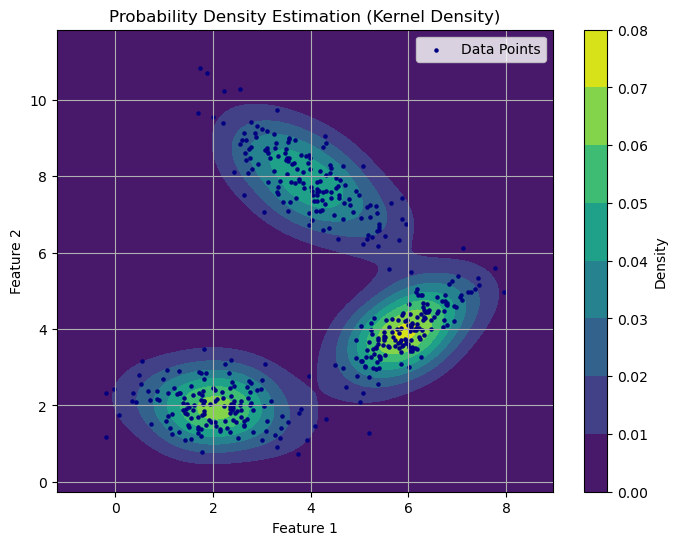

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde

# Custom means and covariances
means = [ [2, 2], [6, 4], [4, 8] ]
covs = [
    [[1.0, 0.0], [0.0, 0.3]],  # narrow vertical ellipse
    [[0.5, 0.4], [0.4, 0.5]],  # slanted ellipse
    [[1.0, -0.8], [-0.8, 1.0]] # elongated diagonal ellipse
]

X = np.vstack([
    np.random.multivariate_normal(mean, cov, size=150)
    for mean, cov in zip(means, covs)
])

# Grid over which we will evaluate KDE
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))
grid_coords = np.vstack([xx.ravel(), yy.ravel()]).T

# KDE using sklearn
kde = KernelDensity(bandwidth=0.6, kernel='gaussian')
kde.fit(X)
log_density = kde.score_samples(grid_coords)
density = np.exp(log_density).reshape(xx.shape)

# Plotting
plt.figure(figsize=(8, 6))
plt.title("Probability Density Estimation (Kernel Density)")
plt.contourf(xx, yy, density, cmap='viridis')
plt.colorbar(label='Density')
plt.scatter(X[:, 0], X[:, 1], s=5, c='navy', label='Data Points')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()

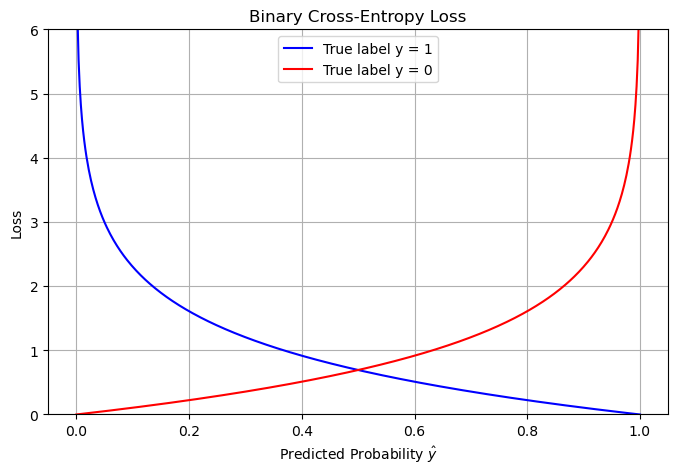

In [ ]:
# Predicted probabilities from 0 to 1 (excluding exact 0 and 1 to avoid log(0))
y_hat = np.linspace(1e-5, 1 - 1e-5, 500)

# BCE when the true label y = 1
bce_y1 = -np.log(y_hat)

# BCE when the true label y = 0
bce_y0 = -np.log(1 - y_hat)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(y_hat, bce_y1, label='True label y = 1', color='blue')
plt.plot(y_hat, bce_y0, label='True label y = 0', color='red')
plt.title('Binary Cross-Entropy Loss')
plt.xlabel('Predicted Probability $\\hat{y}$')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.ylim(0, 6)
plt.show()